## The Matryoshka Dataset Using Example. Visual Based Recommendations

###1. Import of Required Modules

In [ ]:
%pip install timm
%pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import cv2
import timm
import json
import random 

import torch
import torchvision.transforms.functional as tf

import numpy as np
import pandas as pd

from tqdm import tqdm

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import top_k_accuracy_score
from sklearn.utils import shuffle


import matplotlib.pyplot as plt
from google.colab import files
import seaborn as sns
sns.set_theme(style="whitegrid")
%matplotlib inline

####1.1 Utility Functions

In [ ]:
def json2csv(root_dir, file_name='matryoshka.json'):
    with open(os.path.join(root_dir, file_name), encoding='utf-8', mode='r') as f:
        json_data = json.load(f)

    images=[]
    models=[]

    for img_id in json_data:
        img_data = json_data[img_id]
        images.append(os.path.join(root_dir, img_data['category'], img_data['brand'], img_data['model'], img_data['img']))
        models.append(img_data['model'])

    df_data = {'image': images, 'model': models}
    df = pd.DataFrame(df_data)

    df['model'] = df['model'].astype('category')
    df['model_id'] = df['model'].cat.codes
    return df

def train_test_split(df, train_percent=.8, seed=None):
  np.random.seed(seed)
  perm = np.random.permutation(df.shape[0])
  train_end = int(train_percent * df.shape[0])
  train = df.iloc[perm[:train_end]]
  test = df.iloc[perm[train_end:]]
  return train, test


def accurate_split(matryoshka_df, train_sz=0.8, seed=42):
    train_dfs = []
    test_dfs = []

    uniques_df = matryoshka_df.drop_duplicates(subset=['model'])
    train_ids = uniques_df['model'].to_numpy()

    for class_id in train_ids:
        model_df = matryoshka_df[ matryoshka_df['model'] == class_id].copy()

        if int(min(train_sz, (1. - train_sz)) * model_df.size) > 0:
            train_df, test_df = \
                train_test_split(model_df, train_sz, seed=seed)

            train_dfs.append(train_df)
            test_dfs.append(test_df)
        else:
            train_dfs.append(model_df)

    train_df = pd.concat(train_dfs, ignore_index=True)
    test_df = pd.concat(test_dfs, ignore_index=True)

    train_df = shuffle(train_df)
    test_df = shuffle(test_df)

    return train_df, test_df

def train_test_dfs(train_dir, test_dir, json_file='matryoshka.json'):
    train_df = json2csv(train_dir, json_file)
    test_df = json2csv(test_dir, json_file)
    df = pd.concat([train_df, test_df])
    train_df, test_df = accurate_split(df)
    return train_df, test_df

###2. Loading Dataset

####2.1 Train Data Loading

In [ ]:
!wget https://www.dropbox.com/s/hycv0egyto4m91t/matryoshka_train.zip?dl=0 -O train.zip

--2023-01-23 03:36:33--  https://www.dropbox.com/s/hycv0egyto4m91t/matryoshka_train.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.69.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.69.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/hycv0egyto4m91t/matryoshka_train.zip [following]
--2023-01-23 03:36:34--  https://www.dropbox.com/s/raw/hycv0egyto4m91t/matryoshka_train.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc817f83654bac3d077ef4160bc7.dl.dropboxusercontent.com/cd/0/inline/B1Hiuop1N_NTHzvkQTjGOD1hBPOvQxqREutZt9_Ojv6a8Wa8RzGHd62b5IGY5bLdeHg3-JYCzBTb_eG-pKLyVJRculx3S7-V6Cat2Hn-7PqnOE1bhveooTONyUdK_Ccrbs_w3mjMggEU621tZWczkSUKQQc9D5Syxjn5k3F0Cv0GPw/file# [following]
--2023-01-23 03:36:35--  https://uc817f83654bac3d077ef4160bc7.dl.dropboxusercontent.com/cd/0/inline/B1Hiuop1N_NTHzvkQTjGOD1hBPOvQxqREutZt9_Ojv6a8Wa8

In [ ]:
!ls

sample_data  test.zip  train.zip


In [ ]:
!unzip -q train.zip -d/train

replace /train/matryoshka_train/matryoshka.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
!ls /train/matryoshka_train

dress  jeans_jeggins  matryoshka.json  outerwear  t-shirts


####2.2 Test Data Loading

In [ ]:
!wget https://www.dropbox.com/s/dk9x2ucrkt7r1zc/matryoshka_test.zip?dl=0 -O test.zip

--2023-01-23 03:36:51--  https://www.dropbox.com/s/dk9x2ucrkt7r1zc/matryoshka_test.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.69.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.69.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/dk9x2ucrkt7r1zc/matryoshka_test.zip [following]
--2023-01-23 03:36:53--  https://www.dropbox.com/s/raw/dk9x2ucrkt7r1zc/matryoshka_test.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc087b8916220607752ad919467f.dl.dropboxusercontent.com/cd/0/inline/B1HtfMHelxewMoAy-wu4g4HAPCtgjjDcNZV6HeqDTpar33YzW-LPpOoZ9BerxhQrAizcB3fzkTPe_-Wdn-84Sv2GpVQH9bQL3o4nm7TI4jVkl-KIRSMEF3DQn9hlrArsCSbGG-ID2djopshciCHeeF6REUv5rdMBSqTHtzSqUyeNXw/file# [following]
--2023-01-23 03:36:53--  https://uc087b8916220607752ad919467f.dl.dropboxusercontent.com/cd/0/inline/B1HtfMHelxewMoAy-wu4g4HAPCtgjjDcNZV6HeqDTpar33YzW-L

In [ ]:
!unzip -q test.zip -d/test

replace /test/matryoshka_test/matryoshka.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
!ls /test/matryoshka_test

dress  jeans_jeggins  matryoshka.json  outerwear  t-shirts


#####2.3 Prepare Query and Target Dataframes

In [ ]:
train_df, test_df = train_test_dfs('/train/matryoshka_train', '/test/matryoshka_test','matryoshka.json')

In [ ]:
print('Train images: {}'.format(train_df.shape[0]))
print('Test images: {}'.format(test_df.shape[0]))
print('Total number of images: {}'.format(train_df.shape[0]+test_df.shape[0]))

Train images: 1092
Test images: 327
Total number of images: 1419


In [ ]:
print('Unique models: {}'.format(np.unique(train_df['model'].values).shape[0]+1))

Unique models: 118


###3. Simple Visual Recommendation Engine

####3.1 Main Functions

In [ ]:
MEAN_IMAGENET = [0.485, 0.456, 0.406]
STD_IMAGENET = [0.229, 0.224, 0.225]

def prepare_input(img_path, img_size=(224, 224), train_mean = MEAN_IMAGENET, train_std = STD_IMAGENET):

    img = cv2.imdecode(np.fromfile(img_path, dtype=np.uint8), cv2.IMREAD_UNCHANGED)
    if img is None:
      return None, None

    resize_img = cv2.resize(img, img_size)

    if img.shape[2] == 3:
        rgb_img = cv2.cvtColor(resize_img, cv2.COLOR_BGR2RGB)
    else:
        rgb_img = cv2.cvtColor(resize_img, cv2.COLOR_BGRA2RGB)

    img_tnsr = tf.to_tensor(rgb_img)
    img_tnsr = tf.normalize(img_tnsr, train_mean, train_std)
    img_tnsr = torch.unsqueeze(img_tnsr, 0)

    return img_tnsr, resize_img

def prepare_feature_extractor(backbone='resnet50'):
    extractor = timm.create_model(backbone, pretrained=True, num_classes=0)
    extractor.eval()
    return extractor

def extract_features(img, extractor,  normalize=True):
    feats = extractor(img)
    feats = feats.detach().cpu().numpy() if feats.requires_grad else feats.cpu().numpy()
    feats_flat = feats.flatten()
    if normalize:
        flattened_features = feats_flat / np.linalg.norm(feats_flat)
    return feats_flat

####3.2 Creating the Visual Dictionary


In [ ]:
images = train_df['image'].to_numpy()
images = images.tolist()

labels = train_df['model'].to_numpy()

extr = prepare_feature_extractor()

targets=[]
fts = []
lbs  =[]

for idx in tqdm(range(len(images))):
    tens, img = prepare_input(images[idx])
    if tens is None or img is None:
       continue
    features = extract_features(tens, extr)
    targets.append(img)
    fts.append(features)
    lbs.append(labels[idx])

targets=np.asarray(targets)
fts  = np.asarray(fts)
lbs  = np.asarray(lbs)
   
knn  = KNeighborsClassifier(n_neighbors=5)
knn.fit(fts, lbs)

100%|██████████| 1092/1092 [02:32<00:00,  7.16it/s]


KNeighborsClassifier()

####3.3 Top-N Recommendations Accuracy Estimation

In [ ]:
images = test_df['image'].to_numpy()
images = images.tolist()

labels = test_df['model'].to_numpy()

queries =[]
fts = []
lbs = []
for idx in tqdm(range(len(images))):
   tens, img = prepare_input(images[idx])
   if tens is None or img is None:
      continue
   features = extract_features(tens, extr)
   queries.append(img)
   fts.append(features)
   lbs.append(labels[idx])

fts = np.asarray(fts)
lbs = np.asarray(lbs)
probs = knn.predict_proba(fts)
   
print('Top-3 Accuracy: {:.2f}'.format(top_k_accuracy_score(lbs, probs, k=3)*100.))
print('Top-5 Accuracy: {:.2f}'.format(top_k_accuracy_score(lbs, probs, k=5)*100.))

100%|██████████| 327/327 [00:45<00:00,  7.26it/s]


Top-3 Accuracy: 70.95
Top-5 Accuracy: 78.29


####3.4 Queries Samples

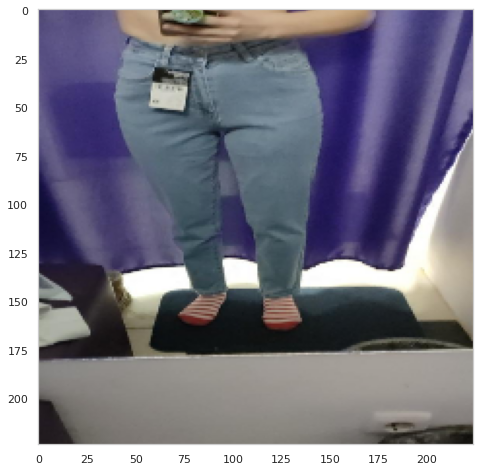

In [ ]:
qidx = random.randint(0, len(queries))
img = cv2.cvtColor(queries[qidx], cv2.COLOR_RGB2BGR)
ids=knn.kneighbors([fts[qidx]], n_neighbors=5, return_distance=False)
fig = plt.figure(figsize=(8., 8.))
ids=ids.flatten()
ids=ids.tolist()
plt.imshow(img)
plt.grid(False)

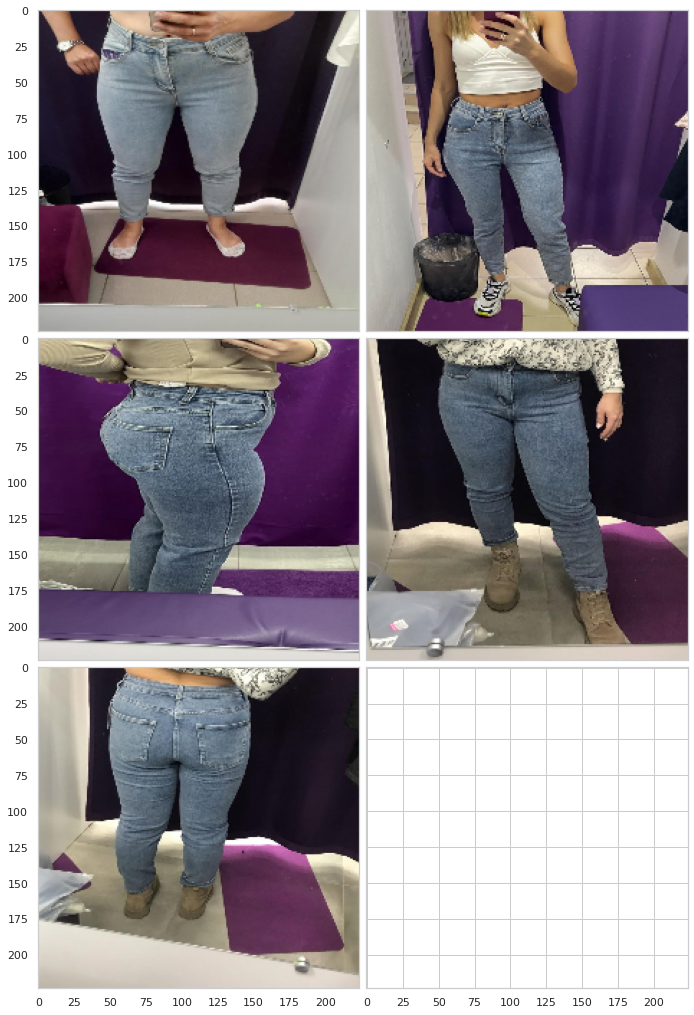

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(18., 18.))
grid = ImageGrid(fig, 111, nrows_ncols=(3, 2), axes_pad=0.1,)
samples= targets[ids] 
for ax, im in zip(grid, samples): 
    im = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
    ax.imshow(im)
    ax.grid(False)